In [1]:
from keras.datasets import boston_housing
from keras import models
from keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [2]:
(train_data, train_target), (test_data, test_target) = boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
# 标准化
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std
test_data = (test_data - mean)/std #注意在工作中不能使用来自测试数据的计算结果
test_data

array([[ 1.55369355, -0.48361547,  1.0283258 , ...,  0.78447637,
        -3.48459553,  2.25092074],
       [-0.39242675, -0.48361547, -0.16087773, ..., -0.30759583,
         0.42733126,  0.47880119],
       [-0.39982927, -0.48361547, -0.86940196, ...,  0.78447637,
         0.44807713, -0.41415936],
       ...,
       [-0.20709507, -0.48361547,  1.24588095, ..., -1.71818909,
         0.37051949, -1.49344089],
       [-0.36698601, -0.48361547, -0.72093526, ..., -0.48960787,
         0.39275481, -0.41829982],
       [-0.0889679 , -0.48361547,  1.24588095, ..., -1.71818909,
        -1.21946544, -0.40449827]])

In [5]:
#构建模型
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu'))    #训练数据较少，使用较少隐藏层的小型网络，以避免过拟合
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))     #最后一层只有一个单元，并且没有激活函数， 是一个线性层， 这是标量回归的典型设置（预测单一连续值的回归）
    model.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mae'])     #mae: mean absolute error, 预测值与目标值之差的绝对值
    return model

In [6]:
#k折验证
k = 4
num = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num : (i+1) * num]          #验证数据
    val_target = train_target[i * num : (i+1 ) * num]
    
    train_data_part = np.concatenate([train_data[: i * num] , train_data[(i+1) * num:]], axis = 0)          #训练数据
    train_target_part = np.concatenate([train_target[: i*num] , train_target[(i+1)* num : ]], axis =0)
    
    model = build_model()
    history = model.fit(train_data_part, train_target_part, validation_data=(val_data, val_target), epochs = num_epochs, batch_size = 16, verbose = 0)   #verbose = 0 静默模式
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)


# num_epochs = 500
# num_val_samples = len(train_data) // k
# all_mae_histories = []
# for i in range(k):
#     print(f"Processing fold #{i}")
#     val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
#     val_targets = train_target[i * num_val_samples: (i + 1) * num_val_samples]
#     partial_train_data = np.concatenate(
#         [train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],
#         axis=0)
#     partial_train_targets = np.concatenate(
#         [train_target[:i * num_val_samples],
#          train_target[(i + 1) * num_val_samples:]],
#         axis=0)
#     model = build_model()
#     history = model.fit(partial_train_data, partial_train_targets,
#                         validation_data=(val_data, val_targets),
#                         epochs=num_epochs, batch_size=16, verbose=0)
#     mae_history = history.history["val_mae"]
#     all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


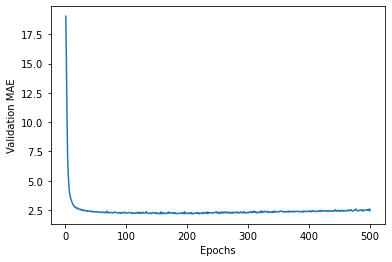

In [7]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

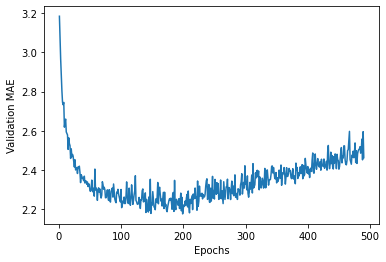

In [8]:
truncated_mae_history = average_mae_history[10:]                       #纵轴过大，故删除前十个点
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()                

In [13]:
model = build_model()
model.fit(train_data, train_target,
epochs=110, batch_size=16, verbose=0)       #发现在100轮之后开始过拟合，重新构建模型，epochsz = 110左右
test_mse_score, test_mae_score = model.evaluate(test_data, test_target)   #检测模型

4/4 [==============================] - 0s 675us/step - loss: 17.3696 - mae: 2.6427
